In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp

from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import corner
import importlib
import logging

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [2]:
training_data = np.load("./nsi_data/sample_nsi_regression_1e7_v1.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

# theta13, theta23, delta, mumu, emu, etau
target = np.column_stack([training_data["theta13"]/180, training_data["theta23"]/180,
                          np.sin(training_data["delta"]/180*np.pi), np.cos(training_data["delta"]/180*np.pi),
                         training_data["mumu"], training_data["emu"],
                         training_data["etau"]])

x_train = data_all[:90]
y_train = target[:90]

x_train_poisson = np.random.poisson(x_train)/1000

In [4]:
gaussian_number = 100
latent_dim = 40
index = 1

path = './CVAE/DNN_angleTran_allparam_' + str(gaussian_number) + ',' + str(latent_dim) + '_{}'.format(index)
encoder1 = load_model(path + "/encoder_1.h5", compile=False)
encoder2 = load_model(path + "/encoder_2.h5", compile=False)
decoder = load_model(path + "/decoder.h5", compile=False)

In [6]:
n = 0
data_poisson_array = x_train[n:n+1]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, gaussian_number, latent_dim))
log_var = tf.reshape(log_var, (-1, gaussian_number, latent_dim))
weight = tf.reshape(weight, (-1, gaussian_number))

SMALL_CONSTANT = 1e-10
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 100000
sample_times = 10
prediction = []
for i in range(sample_times):

    Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, latent_dim))
    target_array = np.reshape([data_poisson_array for i in range(sample_amount)], (sample_amount, 144))
    reconstruction_mean, reconstruction_var = decoder.predict([Z3, target_array])
    temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
    reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                            loc=reconstruction_mean,
                            scale_diag= tf.sqrt(temp_var))
    prediction.extend(reconstruction_parameter.sample().numpy())

prediction = np.array(prediction)

In [7]:
degree = np.angle(prediction[:,3] + 1j*np.array(prediction[:,2]), deg=True)
degree = [d if d > 0 else 360+d for d in degree]
prediction2 = np.column_stack([prediction[:,:2]*180/np.pi, degree, prediction[:, 4:]])

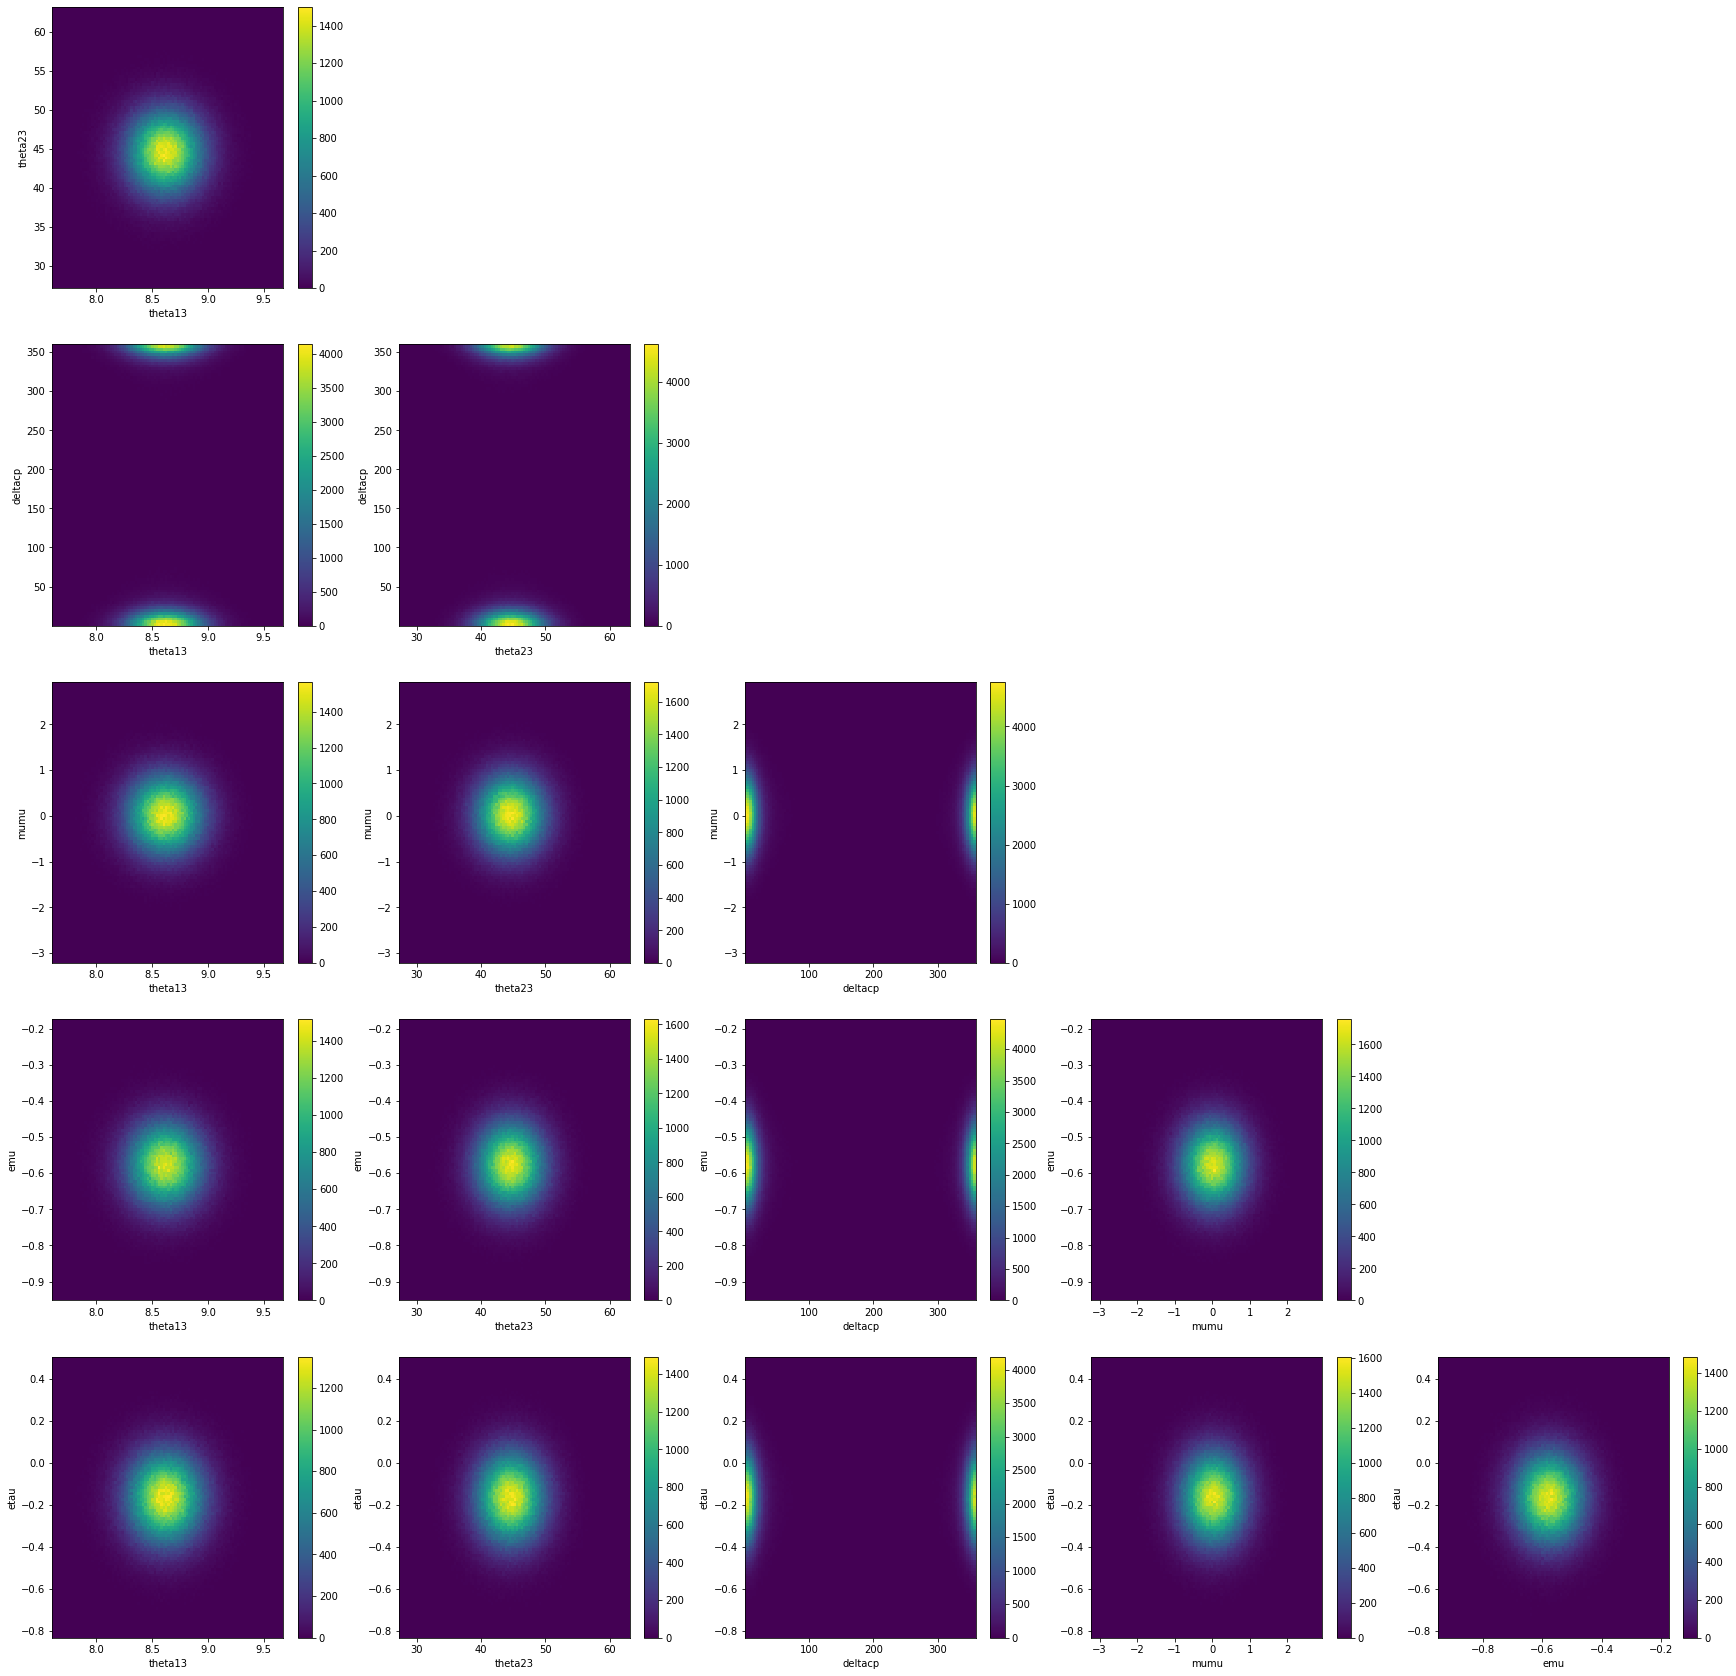

In [18]:
label = ["theta13", "theta23", 'deltacp', 'mumu', 'emu', 'etau']
index = [1,6,11,16,21,7,12,17,22,13,18,23,19,24,25]
k = 0
plt.figure(figsize = (30, 30))
for i in range(len(prediction2[0])):
    for j in range(i+1, len(prediction2[0])):
        plt.subplot(5, 5, index[k])
        plt.hist2d(prediction2[:,i], prediction2[:,j], bins = 100)
        plt.xlabel(label[i])
        plt.ylabel(label[j])
        plt.colorbar()
        k += 1
plt.show()

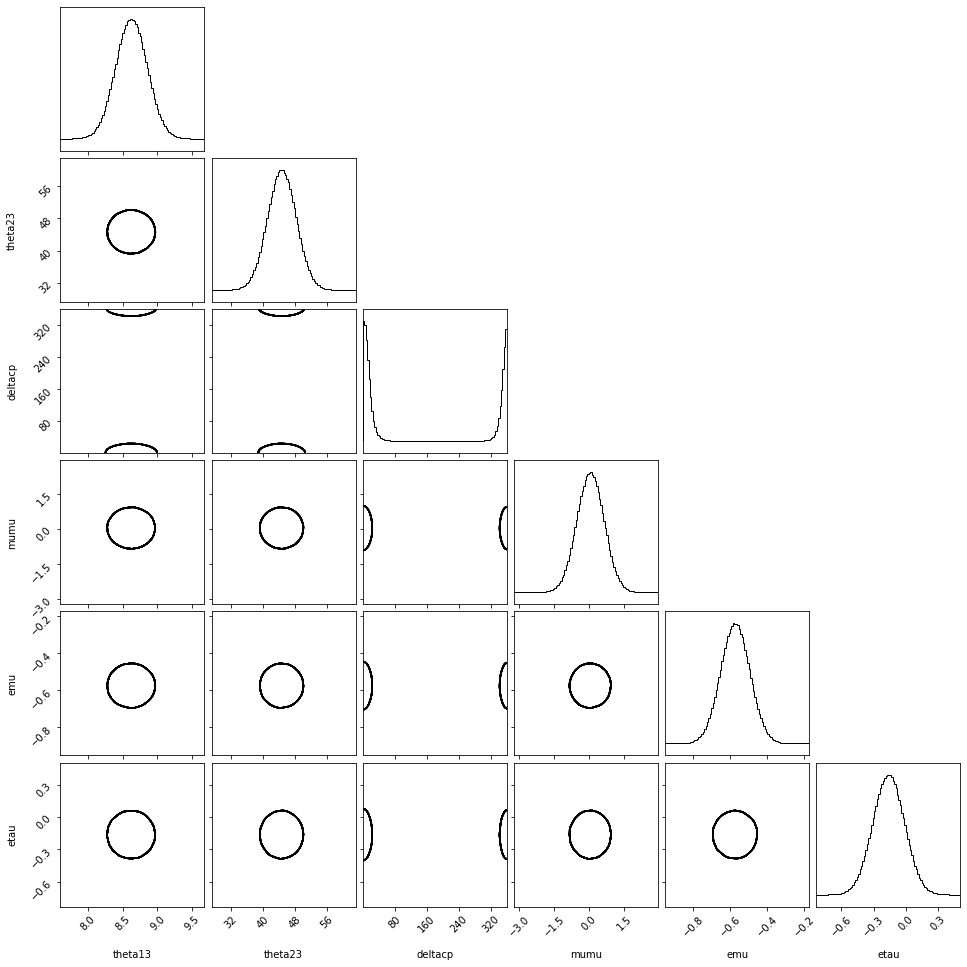

In [19]:
figure = corner.corner(prediction2,
                    levels = [[0.68] for i in range(15)],
                    scale_hist=True,
                    plot_datapoints=False,
                    labels = label,
                    plot_contours = True,
                    plot_density = False,
                    bins=100,
                    smooth=True
                    )

In [20]:
def plot_graph(x, y, c, i, name):
    plt.scatter(x, y, c=c)
    plt.colorbar()
    plt.title('data{}_chi-square value'.format(i))
    plt.xlabel('$\\theta_{23}$ (degree)')
    plt.ylabel('$\delta_{cp}$ (degree)')
    plt.clim(0,)
    plt.savefig('./graph/data '.format(i) + name)
    plt.show()

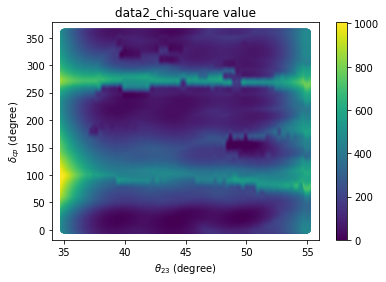

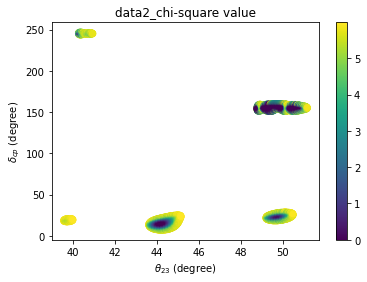

In [21]:
for i in range(n+1, n+2):
    a = np.loadtxt('./chi_theta23_delta_contour/chi_theta23_delta_v{}.dat'.format(i))
    arr = list(zip(*a))
    x0 = sorted(set(arr[0]))
    y0 = sorted(set(arr[1]))
    z0 = np.reshape(arr[2], (81, 37))
    f = RectBivariateSpline(x0, y0, z0)
    xnew = np.linspace(35, 55, 1000)
    ynew = np.linspace(0, 360, 1000)
    znew = f(xnew, ynew)
    mx, my = np.meshgrid(ynew, xnew)
    x = np.reshape(mx, 1000000)
    y = np.reshape(my, 1000000)
    z = np.reshape(znew, 1000000)
    plot_graph(y, x, z, i , 'chi-square value_full (RectBivariateSpline)')
    loc = np.where(z < 5.99)
    plot_graph(y[loc], x[loc], z[loc], i, 'chi-square value_two_sigma (RectBivariateSpline)')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'label'


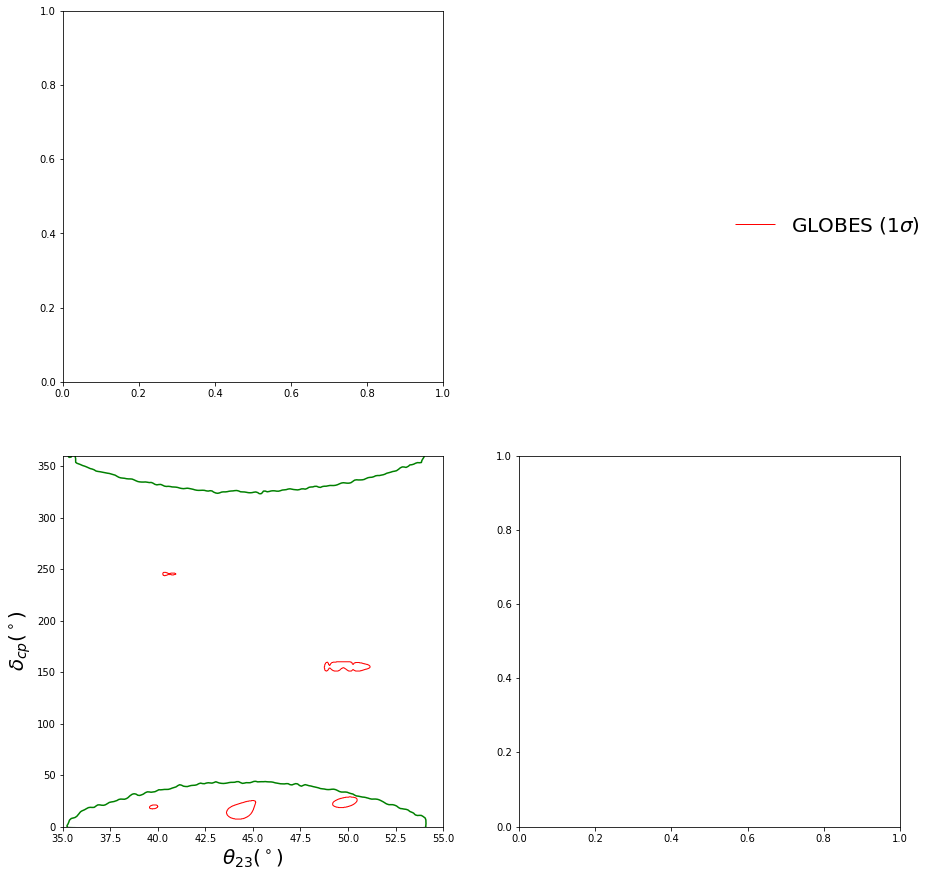

In [22]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis = plt.subplot(2,2,4)
plot_axis = plt.subplot(2,2,3)
r1 = corner.hist2d(prediction2[:, 1], prediction2[:, 2],
                    levels=(0.95,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    range=[[35,55], [0, 360]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [200, 200],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
one_sigma_region_boundary = np.where(znew > 5.99, 1, 0 )
r2 = CS_1_sigma = plot_axis.contour(xnew, ynew, one_sigma_region_boundary.T, 0, colors='red', linestyles="-", linewidths=1, label = 'Prediction')
plot_axis.set_xlabel("$\\theta_{23} $($^\circ$)", fontsize = 20)
plot_axis.set_ylabel("$\delta_{cp} $($^\circ$)", fontsize = 20)
r2.collections[0].set_label("GLOBES (1$\sigma$)")
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()